# Intel Image dataset: experimentation

This notebook outlines experimental steps to build a Neural Network model for image classification using Tensorflow and Keras. Steps and explanations are fairly verbose as this is a learning exercise to understand the tensorflow toolkit while applying it to a real-world problem.

The image data used is the Intel Image Classification set from Kaggle: https://www.kaggle.com/puneet6060/intel-image-classification

This Data contains around 25k images of size 150x150 distributed under 6 categories:
- buildings: 0
- forest: 1
- glacier: 2
- mountain: 3
- sea: 4
- street: 5 


**Import libraries and set configuration**

In [6]:
import os
import shutil
import zipfile
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorboard.plugins.hparams import api as hp

In [60]:
# enable image display in Jupyter and set float format
%matplotlib inline
from IPython.display import Image, display
pd.options.display.float_format = "{:,.0f}".format

**Navigation**

The data has been downloaded from Kaggle as a zip archive. Within this, the images have been organised into train, test and prediction folders. The train and test folders also have further subdirectories where images have been sorted into their respective classes (they have been labelled already). Let's begin by create path variables to point at all these locations.

In [8]:
base_dir = r'C:\Users\eddlo\Python\Projects\TF-images'
data_dir = os.path.join(base_dir,'data')

In [9]:
# set paths to train, test and pred folders
dir_train = os.path.join(data_dir,'seg_train','seg_train')
dir_test = os.path.join(data_dir,'seg_test','seg_test')
dir_pred = os.path.join(data_dir,'seg_pred','seg_pred')

# set paths for each class in train folder
dir_train_buildings = os.path.join(dir_train,'buildings')
dir_train_forest = os.path.join(dir_train,'forest')
dir_train_glacier = os.path.join(dir_train,'glacier')
dir_train_mountain = os.path.join(dir_train,'mountain')
dir_train_sea = os.path.join(dir_train,'sea')
dir_train_street = os.path.join(dir_train,'street')

# do same for test folder
dir_test_buildings = os.path.join(dir_test,'buildings')
dir_test_forest = os.path.join(dir_test,'forest')
dir_test_glacier = os.path.join(dir_test,'glacier')
dir_test_mountain = os.path.join(dir_test,'mountain')
dir_test_sea = os.path.join(dir_test,'sea')
dir_test_street = os.path.join(dir_test,'street')

**Explore the data in the training set**

Firstly, let's look at how many images there are of each class in the training set, and display an example of each one.

There are 2191 images of buildings in the training set. Sample:


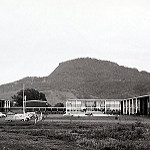

There are 2271 images of forests in the training set. Sample:


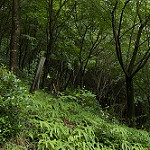

There are 2404 images of glaciers in the training set. Sample:


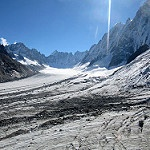

There are 2512 images of mountains in the training set. Sample:


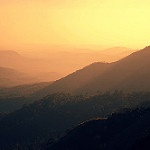

There are 2274 images of seas in the training set. Sample:


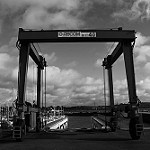

There are 2382 images of streets in the training set. Sample:


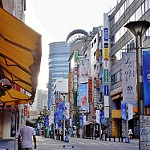

In [5]:
# Look at sample images of each class
print(f"There are {len(os.listdir(dir_train_buildings))} images of buildings in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_buildings, os.listdir(dir_train_buildings)[0])}"))
print(f"There are {len(os.listdir(dir_train_forest))} images of forests in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_forest, os.listdir(dir_train_forest)[0])}"))
print(f"There are {len(os.listdir(dir_train_glacier))} images of glaciers in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_glacier, os.listdir(dir_train_glacier)[0])}"))
print(f"There are {len(os.listdir(dir_train_mountain))} images of mountains in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_mountain, os.listdir(dir_train_mountain)[0])}"))
print(f"There are {len(os.listdir(dir_train_sea))} images of seas in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_sea, os.listdir(dir_train_sea)[0])}"))
print(f"There are {len(os.listdir(dir_train_street))} images of streets in the training set. Sample:")
display(Image(filename=f"{os.path.join(dir_train_street, os.listdir(dir_train_street)[0])}"))

It would be useful to understand the balance of classes in both training and test sets, and how the data has been split between training and testing. 

In [10]:
dirs_train = [dir_train_buildings,dir_train_forest,dir_train_glacier,dir_train_mountain,dir_train_sea,dir_train_street]
dirs_test = [dir_test_buildings,dir_test_forest,dir_test_glacier,dir_test_mountain,dir_test_sea,dir_test_street]
cols = ['buildings','forests','glaciers','mountains','seas','streets']

tot_train = sum([len(os.listdir(d)) for d in dirs_train])
tot_test = sum([len(os.listdir(d)) for d in dirs_test])
    
train_counts = [[len(os.listdir(d)),(len(os.listdir(d))/tot_train)*100] for d in dirs_train]
test_counts = [[len(os.listdir(d)),(len(os.listdir(d))/tot_test)*100] for d in dirs_test]

In [11]:
class_counts_train = pd.DataFrame(data=np.array(train_counts).T,columns=cols)
class_counts_train['Training data'] = ['Count','Proportion (%)']
class_counts_train.set_index('Training data',inplace=True)

class_counts_test = pd.DataFrame(data=np.array(test_counts).T,columns=cols)
class_counts_test['Test data'] = ['Count','Proportion (%)']
class_counts_test.set_index('Test data',inplace=True)

print(class_counts_train)
print('\n')
print(class_counts_test)
print('\n')
print(f"The training split is {100*tot_train/(tot_train+tot_test):.2f}% of the total dataset")

                buildings  forests  glaciers  mountains  seas  streets
Training data                                                         
Count               2,191    2,271     2,404      2,512 2,274    2,382
Proportion (%)         16       16        17         18    16       17


                buildings  forests  glaciers  mountains  seas  streets
Test data                                                             
Count                 437      474       553        525   510      501
Proportion (%)         15       16        18         18    17       17


The training split is 82.39% of the total dataset


**Simple subset of data**

Some files are held in a separate directory to reduce problem to simple binary classification as a learning exercise.

In [12]:
dir_train_sub = os.path.join(data_dir,'sub_train')
dir_test_sub = os.path.join(data_dir, 'sub_test')

### Model development, training and evaluation

Now, that we are confident we have a clean and well-balanced dataset that is organised into directories according to label, we can proceed to the model building stage. Given this is a large dataset and a complex problem that will require a significant time for the model to train, the following strategy will be undertaken:
 1. Initially reduce the problem to binary classification with only two of the classes
 2. Initially only use a subset of the data (1000 images) for training
 3. Start with a simple network architecture

### Simple Binary classification exercise

**Prepare data for model training**

Keras's `ImageDataGenerator` can be used to feed your model with raw, rescaled or even augmented image data. Here, it will be used to:
- Normalize pixel values
- Standardize image resolutions
- Set a batch size for inference


The `flow_from_directory` method is used to read from the required directory

In [6]:
# point generator to training data (also standardize resolutions and set a batch size)
# class_mode "binary" refers to a 1D output of labels rather that "categorical" which is 2D OHE
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        dir_train_sub,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# point generator to test data (also standardize resolutions and set a batch size)
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        dir_test_sub,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
# sanity check to confirm class labels
print(f"labels in the train generator are: {train_generator.class_indices}")
print(f"labels in the validation generator are: {validation_generator.class_indices}")

# Get a batch of 32 images along with their true label and check shapes (32 images of shape 150x150)
data_imgs, labels = next(validation_generator)
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

labels in the train generator are: {'forest': 0, 'sea': 1}
labels in the validation generator are: {'forest': 0, 'sea': 1}
data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32,)


**Model building, training**

Define the model architecture, hyperparameters and compile accordingly.

For an interface to evaluate and debug different runs of the model's training, we can use the Tensorboard tool. Define a location for logs, and configure the log writer with your chosen hyperparams. Tensorboard callback should be pointed at log directory.

In [12]:
# define hyperparams and metrics
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_NUM_LAYERS = hp.HParam('num_hidden', hp.Discrete([1, 2, 3]))
#HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_ACTIVATION = hp.HParam('activation',hp.Discrete(['relu','sigmoid']))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.001, 0.01, 0.1]))
METRIC_ACCURACY = "accuracy"
                                                    
# configure tensorboard to track hyperparameter values / network architecture
logdir = os.path.join(os.curdir,"logs/binary/hparam_tuning")

# create log writing config
with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_ACTIVATION, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )                                                                                                                   

In [13]:
# define a function for training the model
def train_binary_clf(hparams):
    '''Returns validation accuracy after build, compilation and training of model with input hyperparams'''
    
    # build
    model_simple_binary = models.Sequential()
    model_simple_binary.add(layers.Flatten(input_shape=(150,150,3)))
    for i in range(hparams[HP_NUM_LAYERS]):
        model_simple_binary.add(layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION]))
    model_simple_binary.add(layers.Dense(1, activation="sigmoid"))
    
    # compile
    model_simple_binary.compile(
        loss="binary_crossentropy",
        optimizer=tf.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE]),
        metrics=["accuracy"])
    
    # train
    history = model_simple_binary.fit(
        x=train_generator,
        epochs=3,
        validation_data=validation_generator,
        callbacks=[keras.callbacks.TensorBoard(logdir)])
      
    return history.history['val_accuracy'][-1]


In [ ]:
# define function to run model and store hyperparams/metrics
def run(train_model, run_logdir, hparams):
    '''Wrapper for train model function that logs hyperparams and scores to tensorboard'''
    with tf.summary.create_file_writer(run_logdir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [15]:
# loop through each set of hyperparams, running model and logging results
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for num_layers in HP_NUM_LAYERS.domain.values:
        for activation in (HP_ACTIVATION.domain.values):
            for learning_rate in HP_LEARNING_RATE.domain.values:

                hparams = {
                HP_NUM_UNITS: num_units,
                HP_NUM_LAYERS: num_layers,
                HP_ACTIVATION: activation,
                HP_LEARNING_RATE: learning_rate,
                }
                
                run_name = f"run-{session_num}"
                print(f'--- Starting trial: {run_name}')
                print({h.name: hparams[h] for h in hparams})
                run(train_binary_clf, os.path.join(logdir, run_name), hparams)
                session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'num_hidden': 1, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/3
32/32 [==============================] - 2s 44ms/step - loss: 0.5897 - accuracy: 0.6760 - val_loss: 0.4905 - val_accuracy: 0.8200
Epoch 2/3
32/32 [==============================] - 1s 40ms/step - loss: 0.5053 - accuracy: 0.7400 - val_loss: 0.4224 - val_accuracy: 0.7800
Epoch 3/3
32/32 [==============================] - 1s 40ms/step - loss: 0.4293 - accuracy: 0.8030 - val_loss: 0.4099 - val_accuracy: 0.8600
--- Starting trial: run-1
{'num_units': 16, 'num_hidden': 1, 'activation': 'relu', 'learning_rate': 0.01}
Epoch 1/3
32/32 [==============================] - 2s 43ms/step - loss: 0.7853 - accuracy: 0.5070 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 2/3
32/32 [==============================] - 1s 39ms/step - loss: 0.6815 - accuracy: 0.5350 - val_loss: 0.6667 - val_accuracy: 0.8100
Epoch 3/3
32/32 [==============================] - 1s 34ms/step - loss: 0.6479 - accura

--- Starting trial: run-31
{'num_units': 32, 'num_hidden': 3, 'activation': 'relu', 'learning_rate': 0.01}
Epoch 1/3
32/32 [==============================] - 2s 44ms/step - loss: 0.6437 - accuracy: 0.5860 - val_loss: 0.5590 - val_accuracy: 0.7400
Epoch 2/3
32/32 [==============================] - 1s 39ms/step - loss: 0.5300 - accuracy: 0.7570 - val_loss: 0.4586 - val_accuracy: 0.8000
Epoch 3/3
32/32 [==============================] - 1s 36ms/step - loss: 0.4548 - accuracy: 0.7940 - val_loss: 0.4655 - val_accuracy: 0.8100
--- Starting trial: run-32
{'num_units': 32, 'num_hidden': 3, 'activation': 'relu', 'learning_rate': 0.1}
Epoch 1/3
32/32 [==============================] - 2s 46ms/step - loss: 20.7630 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/3
32/32 [==============================] - 1s 42ms/step - loss: 0.6935 - accuracy: 0.4840 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/3
32/32 [==============================] - 1s 43ms/step - loss: 0.6934 - accur

**Access Tensorboard UI**

Run the following at the terminal (you must be in the ./notebooks directory) to spin up tensorboard.
```
tensorboard --logdir=./logs/binary/hparam_tuning --port=6006
```
Navigate to http://localhost:6006/ to view tensorboard.

**Pros/Cons on using Tensorboard**

Pros of tensorboard:
 - really easy to set up to just view learning rates for debugging
 - keeps everything within the TF framework

Problems with using Tensorboard
 - can't work out how to link hyperparams back to run_ids to get all information on training
 - doesn't save model so you have to recreate it 
 - awkward and difficult to use makes it inflexible
 - limited documentation
 
Recommendations:
 - continue to use TB to view learning rates
 - switch over to MLFlow for hyperparameter logging and storing models

### Multi-class classification exercise

**Prepare data for model training**

In order to trial different models quickly, we may want to use a subset of the ~14000 images to train our model. This can be achieved by using the *ImageDataGenerator().flow_from_dataframe()* method, and passing a dataframe containing only the paths of images we wish to include in the subset. Let's start by training the model with only 1000 images.

We can simply pass the larger dataframe to the ImageDataGenerator if we wish to use all the images.

In [18]:
### Training dataset
# use flow from dataframe to select only a subset of the values
images, labels = [], []
for sub_dir in os.listdir(dir_train):
    img_lst = os.listdir(os.path.join(dir_train,sub_dir))
    img_lst = list(map(lambda x:os.path.join(sub_dir,x),img_lst))
    images.extend(img_lst)
    labels.extend([sub_dir]*len(img_lst))
    
# create a dataframe of images and labels, shuffle it then create a subset (1000)
train_img_df = pd.DataFrame({"Images":images,"Labels":labels})      
train_img_df = train_img_df.sample(frac=1).reset_index(drop=True)
train_sub_img_df = train_img_df.copy().head(1000) 

# check balance of classes in the subset
train_sub_img_df.Labels.value_counts()

mountain     199
street       188
glacier      167
forest       161
buildings    150
sea          135
Name: Labels, dtype: int64

In [19]:
### Validation dataset
# use flow from dataframe to select only a subset of the values
images, labels = [], []
for sub_dir in os.listdir(dir_test):
    img_lst = os.listdir(os.path.join(dir_test, sub_dir))
    img_lst = list(map(lambda x:os.path.join(sub_dir,x),img_lst))
    images.extend(img_lst)
    labels.extend([sub_dir]*len(img_lst))
    
# create a dataframe of images and labels, shuffle it then create a subset (600)
test_img_df = pd.DataFrame({"Images":images,"Labels":labels})      
test_img_df = test_img_df.sample(frac=1).reset_index(drop=True) 
test_sub_img_df = test_img_df.copy().head(600) 

# check balance of classes in the subset
test_sub_img_df.Labels.value_counts()

sea          112
glacier      106
street       103
mountain     100
forest        91
buildings     88
Name: Labels, dtype: int64

In [39]:
# normalize pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# point generator to training data directory and chosen 
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_sub_img_df,
        directory=dir_train,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# point generator to test data
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_sub_img_df,
        directory=dir_test,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
print()
print(f"labels in the train generator are: {train_generator.class_indices}")
print(f"labels in the validation generator are: {validation_generator.class_indices}")
print()
data_imgs, labels = next(validation_generator)
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

Found 1000 validated image filenames belonging to 6 classes.
Found 600 validated image filenames belonging to 6 classes.

labels in the train generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
labels in the validation generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32, 6)


**Model building, training and hyperparameter tuning**

Define hyperparams, and configure logging to hyperparams and metrics can be tracked in tensorboard as before.

In [58]:
# define hyperparams and metrics
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128]))
HP_NUM_LAYERS = hp.HParam('num_hidden', hp.Discrete([1, 2, 3]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_ACTIVATION = hp.HParam('activation',hp.Discrete(['relu']))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.001, 0.01]))
METRIC_ACCURACY = "accuracy"
                                                    
# configure tensorboard to track hyperparameter values / network architecture
logdir = os.path.join(os.curdir,"logs/multi/hparam_tuning")

# create log writing config
with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_DROPOUT, HP_ACTIVATION, HP_LEARNING_RATE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )  

In [84]:
# define a simple architecture for multiclass classification
def train_multi_clf(run_logdir, hparams):
    
    # build
    model_simple_multi = models.Sequential()
    model_simple_multi.add(layers.Flatten(input_shape=(150,150,3)))
    for i in range(hparams[HP_NUM_LAYERS]):
        model_simple_multi.add(layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION]))
        model_simple_multi.add(layers.Dropout(rate=hparams[HP_DROPOUT]))
        
    model_simple_multi.add(layers.Dense(6, activation="softmax"))
    
    # compile
    model_simple_multi.compile(
        loss="categorical_crossentropy",
        optimizer=tf.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE]),
        metrics=["accuracy"])
    
    # train
    history = model_simple_multi.fit(
        x=train_generator,
        epochs=30,
        batch_size=32,
        steps_per_epoch=64,
        validation_data=validation_generator,
        callbacks=[keras.callbacks.TensorBoard(run_logdir),
                  keras.callbacks.EarlyStopping(patience=10)])
      
    return history.history['val_accuracy'][-1]
    

In [76]:
# define function to run model and store hyperparams/metrics
def run(train_model, run_logdir, hparams):
    '''Wrapper for train model function that logs hyperparams and scores to tensorboard'''
    with tf.summary.create_file_writer(run_logdir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_model(run_logdir, hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [61]:
# loop through each set of hyperparams, running model and logging results
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for num_layers in HP_NUM_LAYERS.domain.values:
        for dropout in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for activation in (HP_ACTIVATION.domain.values):
                for learning_rate in HP_LEARNING_RATE.domain.values:

                    hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_NUM_LAYERS: num_layers,
                    HP_DROPOUT: dropout,
                    HP_ACTIVATION: activation,
                    HP_LEARNING_RATE: learning_rate,
                    }

                    run_name = f"run-{session_num}"
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run(train_multi_clf, os.path.join(logdir, run_name), hparams)
                    session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'num_hidden': 1, 'dropout': 0.1, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/15
32/32 [==============================] - 3s 89ms/step - loss: 1.7848 - accuracy: 0.2490 - val_loss: 1.6574 - val_accuracy: 0.2850
Epoch 2/15
32/32 [==============================] - 2s 64ms/step - loss: 1.6097 - accuracy: 0.3640 - val_loss: 1.5982 - val_accuracy: 0.3283
Epoch 3/15
32/32 [==============================] - 2s 63ms/step - loss: 1.5395 - accuracy: 0.4030 - val_loss: 1.5586 - val_accuracy: 0.3750
Epoch 4/15
32/32 [==============================] - 2s 59ms/step - loss: 1.4831 - accuracy: 0.4230 - val_loss: 1.4469 - val_accuracy: 0.4167
Epoch 5/15
32/32 [==============================] - 2s 58ms/step - loss: 1.4223 - accuracy: 0.4590 - val_loss: 1.4405 - val_accuracy: 0.4333
Epoch 6/15
32/32 [==============================] - 2s 56ms/step - loss: 1.3896 - accuracy: 0.4720 - val_loss: 1.4649 - val_accuracy: 0.4400
Epoch 7/15
32/32 [=============

32/32 [==============================] - 2s 56ms/step - loss: 1.7574 - accuracy: 0.2370 - val_loss: 1.7485 - val_accuracy: 0.2000
Epoch 5/15
32/32 [==============================] - 2s 56ms/step - loss: 1.7386 - accuracy: 0.2550 - val_loss: 1.7405 - val_accuracy: 0.3033
Epoch 6/15
32/32 [==============================] - 2s 55ms/step - loss: 1.7309 - accuracy: 0.2630 - val_loss: 1.7619 - val_accuracy: 0.2567
Epoch 7/15
32/32 [==============================] - 2s 56ms/step - loss: 1.7116 - accuracy: 0.2670 - val_loss: 1.6784 - val_accuracy: 0.3033
Epoch 8/15
32/32 [==============================] - 2s 56ms/step - loss: 1.6964 - accuracy: 0.2720 - val_loss: 1.7553 - val_accuracy: 0.2517
Epoch 9/15
32/32 [==============================] - 2s 55ms/step - loss: 1.6880 - accuracy: 0.2920 - val_loss: 1.7312 - val_accuracy: 0.2667
Epoch 10/15
32/32 [==============================] - 2s 58ms/step - loss: 1.6457 - accuracy: 0.2900 - val_loss: 1.6963 - val_accuracy: 0.2917
Epoch 11/15
32/32 [====

32/32 [==============================] - 2s 63ms/step - loss: 1.2859 - accuracy: 0.5170 - val_loss: 1.4227 - val_accuracy: 0.4433
Epoch 9/15
32/32 [==============================] - 2s 64ms/step - loss: 1.2512 - accuracy: 0.5120 - val_loss: 1.3999 - val_accuracy: 0.4617
Epoch 10/15
32/32 [==============================] - 2s 65ms/step - loss: 1.2371 - accuracy: 0.5240 - val_loss: 1.3693 - val_accuracy: 0.4750
Epoch 11/15
32/32 [==============================] - 2s 64ms/step - loss: 1.1820 - accuracy: 0.5660 - val_loss: 1.3965 - val_accuracy: 0.4617
Epoch 12/15
32/32 [==============================] - 2s 63ms/step - loss: 1.1695 - accuracy: 0.5710 - val_loss: 1.3863 - val_accuracy: 0.4617
Epoch 13/15
32/32 [==============================] - 2s 63ms/step - loss: 1.1407 - accuracy: 0.6020 - val_loss: 1.3380 - val_accuracy: 0.4867
Epoch 14/15
32/32 [==============================] - 2s 63ms/step - loss: 1.1449 - accuracy: 0.5700 - val_loss: 1.3567 - val_accuracy: 0.4850
Epoch 15/15
32/32 [

32/32 [==============================] - 2s 65ms/step - loss: 1.3251 - accuracy: 0.4710 - val_loss: 1.4173 - val_accuracy: 0.4267
Epoch 13/15
32/32 [==============================] - 2s 70ms/step - loss: 1.3055 - accuracy: 0.4690 - val_loss: 1.3956 - val_accuracy: 0.4483
Epoch 14/15
32/32 [==============================] - 2s 72ms/step - loss: 1.2979 - accuracy: 0.4690 - val_loss: 1.3822 - val_accuracy: 0.4333
Epoch 15/15
32/32 [==============================] - 2s 64ms/step - loss: 1.2661 - accuracy: 0.5010 - val_loss: 1.4648 - val_accuracy: 0.4117
--- Starting trial: run-22
{'num_units': 128, 'num_hidden': 3, 'dropout': 0.2, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/15
32/32 [==============================] - 3s 74ms/step - loss: 1.7862 - accuracy: 0.1860 - val_loss: 1.7366 - val_accuracy: 0.2850
Epoch 2/15
32/32 [==============================] - 2s 67ms/step - loss: 1.7536 - accuracy: 0.2430 - val_loss: 1.7044 - val_accuracy: 0.3017
Epoch 3/15
32/32 [===================

Run the following at the terminal (you must be in the ./notebooks directory) to spin up tensorboard.
```
tensorboard --logdir=./logs/multi/hparam_tuning --port=6006
```
Navigate to http://localhost:6006/ to view tensorboard.

**Training the best-performer using the complete dataset**

In [20]:
# normalize pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# point generator to training data directory and chosen 
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_img_df,
        directory=dir_train,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# point generator to test data
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_img_df,
        directory=dir_test,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
print()
print(f"labels in the train generator are: {train_generator.class_indices}")
print(f"labels in the validation generator are: {validation_generator.class_indices}")
print()
data_imgs, labels = next(validation_generator)
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.

labels in the train generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
labels in the validation generator are: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32, 6)


In [72]:
# train the best performer on the complete dataset
dnn_logdir=os.path.join(os.curdir,"logs/multi/dnn/hparam")
dnn_run_logdir = os.path.join(dnn_logdir, f"run-{time.strftime('%Y_%m_%d-%H_%M_%S')}")

model = models.Sequential([
    layers.Flatten(input_shape=(150,150,3)),
    layers.Dense(512, activation="relu"),
    layers.Dropout(rate=0.2),
    layers.Dense(512, activation="relu"),
    layers.Dropout(rate=0.2),
    layers.Dense(512, activation="relu"),
    layers.Dropout(rate=0.2),
    layers.Dense(6, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"])

history = model.fit(
    x=train_generator,
    epochs=30,
    batch_size=32,
    steps_per_epoch=100,
    validation_data=validation_generator,
    callbacks=[keras.callbacks.TensorBoard(dnn_run_logdir),
              keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
100/100 [==============================] - 9s 89ms/step - loss: 1.7032 - accuracy: 0.2825 - val_loss: 1.5929 - val_accuracy: 0.3440
Epoch 2/30
100/100 [==============================] - 8s 78ms/step - loss: 1.5728 - accuracy: 0.3816 - val_loss: 1.4604 - val_accuracy: 0.4510
Epoch 3/30
100/100 [==============================] - 8s 76ms/step - loss: 1.4881 - accuracy: 0.4194 - val_loss: 1.4277 - val_accuracy: 0.4400
Epoch 4/30
100/100 [==============================] - 8s 77ms/step - loss: 1.4504 - accuracy: 0.4397 - val_loss: 1.3771 - val_accuracy: 0.4750
Epoch 5/30
100/100 [==============================] - 8s 78ms/step - loss: 1.4083 - accuracy: 0.4578 - val_loss: 1.3377 - val_accuracy: 0.5013
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 1.3727 - accuracy: 0.4675 - val_loss: 1.3470 - val_accuracy: 0.4850
Epoch 7/30
100/100 [==============================] - 8s 77ms/step - loss: 1.3824 - accuracy: 0.4544 - val_loss: 1.3457 - val_accuracy: 0.4823

In [83]:
history.history['val_accuracy'][-1]

0.5433333516120911

Run the following at the terminal (you must be in the ./notebooks directory) to spin up tensorboard.
```
tensorboard --logdir=./logs/multi/dnn --port=6006
```
Navigate to http://localhost:6006/ to view tensorboard.

In [22]:
# define a simple architecture for multiclass classification
def train_multi_clf(run_logdir, hparams, epochs=1):
    
    # build
    model_simple_multi = models.Sequential()
    model_simple_multi.add(layers.Flatten(input_shape=(150,150,3)))
    for i in range(hparams[HP_NUM_LAYERS]):
        model_simple_multi.add(layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION]))
        model_simple_multi.add(layers.Dropout(rate=hparams[HP_DROPOUT]))
        
    model_simple_multi.add(layers.Dense(6, activation="softmax"))
    
    # compile
    model_simple_multi.compile(
        loss="categorical_crossentropy",
        optimizer=tf.optimizers.SGD(learning_rate=hparams[HP_LEARNING_RATE]),
        metrics=["accuracy"])
    
    # train
    history = model_simple_multi.fit(
        x=train_generator,
        epochs=epochs,
        batch_size=32,
        steps_per_epoch=64,
        validation_data=validation_generator,
        callbacks=[keras.callbacks.TensorBoard(run_logdir),
                  keras.callbacks.EarlyStopping(patience=10)])
      
    return history.history['val_accuracy'][-1]

In [23]:
# define function to run model and store hyperparams/metrics
def run(train_model, run_logdir, hparams, epochs):
    '''Wrapper for train model function that logs hyperparams and scores to tensorboard'''
    with tf.summary.create_file_writer(run_logdir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_model(run_logdir, hparams, epochs)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [24]:
# hyperparameter tuning for very deep neural networks 
# define hyperparams and metrics
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512]))
HP_NUM_LAYERS = hp.HParam('num_hidden', hp.Discrete([2, 3, 4]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.2]))
HP_ACTIVATION = hp.HParam('activation',hp.Discrete(['relu']))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.001]))
METRIC_ACCURACY = "accuracy"
                                                    
# configure tensorboard to track hyperparameter values / network architecture
logdir = os.path.join(os.curdir,"logs/multi/dnn/hparam_tuning")

# loop through each set of hyperparams, running model and logging results
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for num_layers in HP_NUM_LAYERS.domain.values:
        for dropout in HP_DROPOUT.domain.values:
            for activation in (HP_ACTIVATION.domain.values):
                for learning_rate in HP_LEARNING_RATE.domain.values:

                    hparams = {
                    HP_NUM_UNITS: num_units,
                    HP_NUM_LAYERS: num_layers,
                    HP_DROPOUT: dropout,
                    HP_ACTIVATION: activation,
                    HP_LEARNING_RATE: learning_rate,
                    }

                    run_name = f"run-{session_num}"
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run(train_multi_clf, os.path.join(logdir, run_name), hparams, epochs=30)
                    session_num += 1

--- Starting trial: run-0
{'num_units': 256, 'num_hidden': 2, 'dropout': 0.2, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/30
64/64 [==============================] - 9s 129ms/step - loss: 1.6985 - accuracy: 0.3008 - val_loss: 1.5261 - val_accuracy: 0.4020
Epoch 2/30
64/64 [==============================] - 8s 122ms/step - loss: 1.5324 - accuracy: 0.3872 - val_loss: 1.4427 - val_accuracy: 0.4533
Epoch 3/30
64/64 [==============================] - 8s 120ms/step - loss: 1.4648 - accuracy: 0.4185 - val_loss: 1.4102 - val_accuracy: 0.4663
Epoch 4/30
64/64 [==============================] - 8s 118ms/step - loss: 1.4702 - accuracy: 0.4170 - val_loss: 1.3775 - val_accuracy: 0.4627
Epoch 5/30
64/64 [==============================] - 7s 114ms/step - loss: 1.4324 - accuracy: 0.4351 - val_loss: 1.3766 - val_accuracy: 0.4773
Epoch 6/30
64/64 [==============================] - 7s 117ms/step - loss: 1.4087 - accuracy: 0.4624 - val_loss: 1.3464 - val_accuracy: 0.4807
Epoch 7/30
64/64 [======

Epoch 27/30
64/64 [==============================] - 7s 104ms/step - loss: 1.2978 - accuracy: 0.5073 - val_loss: 1.2619 - val_accuracy: 0.5103
Epoch 28/30
64/64 [==============================] - 7s 105ms/step - loss: 1.2807 - accuracy: 0.5103 - val_loss: 1.2516 - val_accuracy: 0.5167
Epoch 29/30
64/64 [==============================] - 7s 104ms/step - loss: 1.2793 - accuracy: 0.5123 - val_loss: 1.2510 - val_accuracy: 0.5237
Epoch 30/30
64/64 [==============================] - 7s 104ms/step - loss: 1.2768 - accuracy: 0.5000 - val_loss: 1.2393 - val_accuracy: 0.5313
--- Starting trial: run-2
{'num_units': 256, 'num_hidden': 4, 'dropout': 0.2, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/30
64/64 [==============================] - 8s 114ms/step - loss: 1.7768 - accuracy: 0.1948 - val_loss: 1.7082 - val_accuracy: 0.3047
Epoch 2/30
64/64 [==============================] - 7s 109ms/step - loss: 1.7302 - accuracy: 0.2500 - val_loss: 1.6585 - val_accuracy: 0.3493
Epoch 3/30
64/64 [==

64/64 [==============================] - 10s 162ms/step - loss: 1.3715 - accuracy: 0.4761 - val_loss: 1.3195 - val_accuracy: 0.5047
Epoch 18/30
64/64 [==============================] - 10s 160ms/step - loss: 1.3711 - accuracy: 0.4658 - val_loss: 1.3232 - val_accuracy: 0.5013
Epoch 19/30
64/64 [==============================] - 10s 162ms/step - loss: 1.3890 - accuracy: 0.4546 - val_loss: 1.3183 - val_accuracy: 0.4920
Epoch 20/30
64/64 [==============================] - 10s 159ms/step - loss: 1.3428 - accuracy: 0.4857 - val_loss: 1.3346 - val_accuracy: 0.4930
Epoch 21/30
64/64 [==============================] - 10s 160ms/step - loss: 1.3696 - accuracy: 0.4756 - val_loss: 1.3056 - val_accuracy: 0.5007
Epoch 22/30
64/64 [==============================] - 10s 159ms/step - loss: 1.3406 - accuracy: 0.4912 - val_loss: 1.3053 - val_accuracy: 0.5010
Epoch 23/30
64/64 [==============================] - 10s 159ms/step - loss: 1.3593 - accuracy: 0.4800 - val_loss: 1.3016 - val_accuracy: 0.4997
Epoc

**Using convolution neural networks**

In [26]:
# define the model architecture (a simple CNN)
# input_shape of (150,150,3) represents a 150x150 RGB image 
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(6, activation='softmax')
  ])

# Compile the model
model.compile(
  loss="categorical_crossentropy",
  optimizer="sgd",
  metrics=["accuracy"]
)

history = model.fit(
    x=train_generator,
    epochs=30,
    batch_size=32,
    steps_per_epoch=64,
    validation_data=validation_generator,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/30
64/64 [==============================] - 36s 565ms/step - loss: 1.7627 - accuracy: 0.2300 - val_loss: 1.7115 - val_accuracy: 0.4447
Epoch 2/30
64/64 [==============================] - 36s 572ms/step - loss: 1.5971 - accuracy: 0.3848 - val_loss: 1.4072 - val_accuracy: 0.4660
Epoch 3/30
64/64 [==============================] - 36s 570ms/step - loss: 1.4136 - accuracy: 0.4497 - val_loss: 1.2995 - val_accuracy: 0.4833
Epoch 4/30
64/64 [==============================] - 36s 568ms/step - loss: 1.3040 - accuracy: 0.4932 - val_loss: 1.2047 - val_accuracy: 0.5130
Epoch 5/30
64/64 [==============================] - 36s 570ms/step - loss: 1.2439 - accuracy: 0.5190 - val_loss: 1.1864 - val_accuracy: 0.5423
Epoch 6/30
64/64 [==============================] - 36s 566ms/step - loss: 1.1600 - accuracy: 0.5430 - val_loss: 1.1132 - val_accuracy: 0.5563
Epoch 7/30
64/64 [==============================] - 38s 594ms/step - loss: 1.1204 - accuracy: 0.5664 - val_loss: 1.0862 - val_accuracy: 0.5673

### Model evaluation

Let's explore the results of the CNN as it is clearly the best-performer. 
 - First, explore how loss and accuracy in training/validation sets varied through training
 - Second, run the model on a batch of images and have a look at the results to see get an intuition of what the model is doing
 - Third, investigate how the model performed on each class
 
 
 **History**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


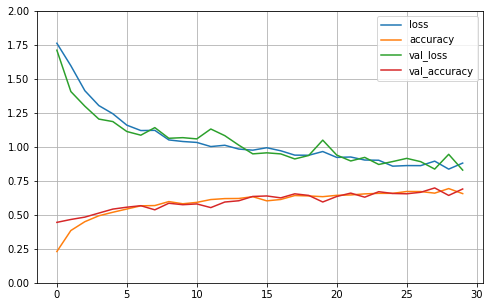

In [27]:
# the history attribute is a dictionary providing scores for each epoch 
print(history.history.keys())

# you can plot these values, which includes accuracy on the training set and accuracy on the validation set
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

**Explore results**

Run the model on a batch of test images to look at what model is getting wrong/right

In [72]:
# run the model on a set of validation data and explore which classes were correctly classified and which were not
X_test, y_test = next(validation_generator)
y_pred = model.predict(x=X_test)

# evaluate the model against the batch of data to get overall accuracy
loss, acc = model.evaluate(x=X_test,y=y_test)

1/1 [==============================] - 0s 96ms/step - loss: 1.0196 - accuracy: 0.5312


In [73]:
# retrieve the class labels from the prediction probabilities into a flattened array (predictions and true)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)

# create a dictionary to get class name from index
labels_idx = {v:k for k,v in validation_generator.class_indices.items()}

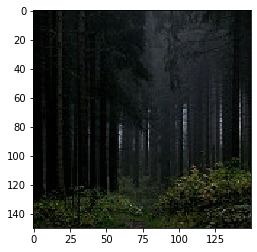

Prediction: forest, Actual: forest


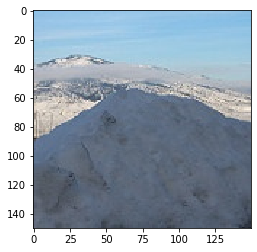

Prediction: mountain, Actual: mountain


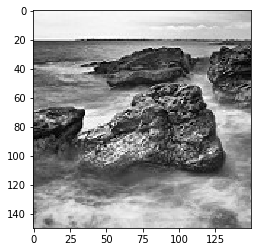

Prediction: street, Actual: sea


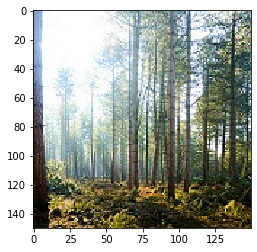

Prediction: buildings, Actual: forest


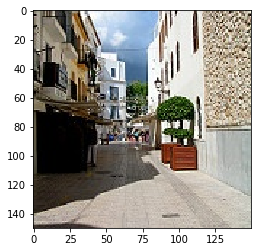

Prediction: street, Actual: street


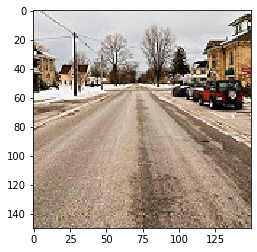

Prediction: street, Actual: street


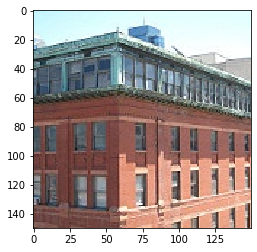

Prediction: buildings, Actual: buildings


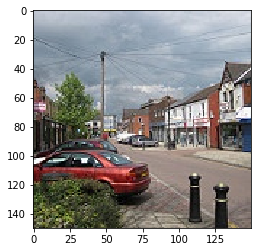

Prediction: buildings, Actual: street


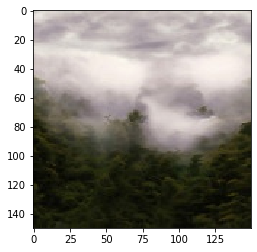

Prediction: mountain, Actual: mountain


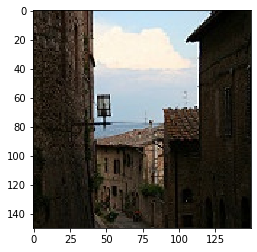

Prediction: street, Actual: street


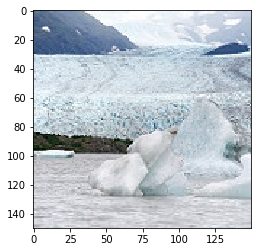

Prediction: glacier, Actual: glacier


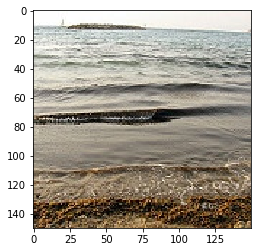

Prediction: sea, Actual: sea


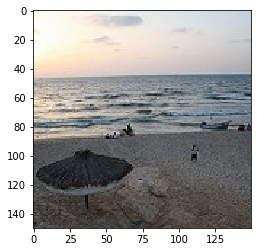

Prediction: mountain, Actual: sea


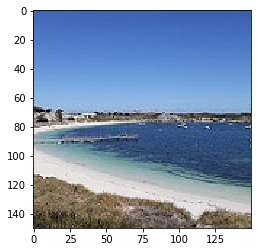

Prediction: glacier, Actual: sea


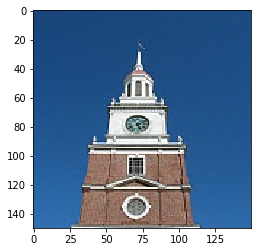

Prediction: sea, Actual: buildings


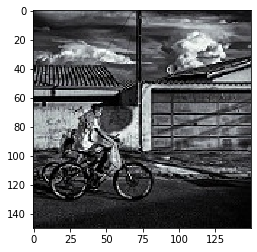

Prediction: buildings, Actual: street


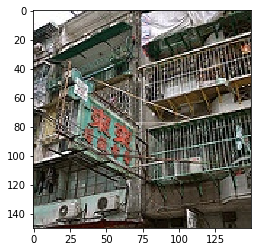

Prediction: forest, Actual: buildings


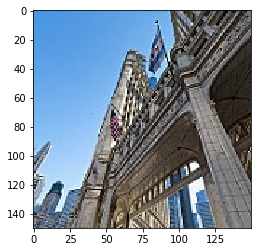

Prediction: buildings, Actual: buildings


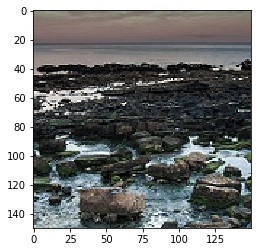

Prediction: buildings, Actual: sea


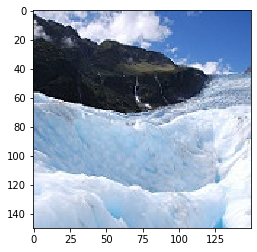

Prediction: glacier, Actual: glacier


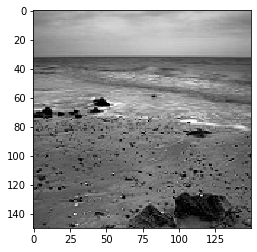

Prediction: sea, Actual: sea


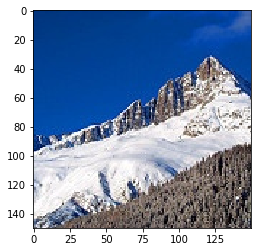

Prediction: glacier, Actual: mountain


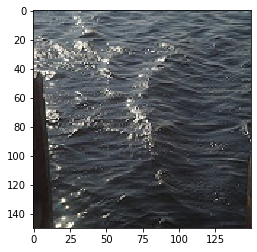

Prediction: buildings, Actual: sea


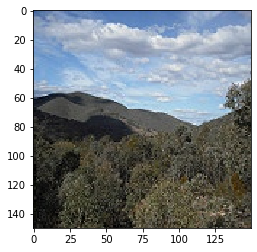

Prediction: mountain, Actual: mountain


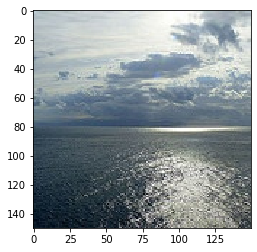

Prediction: mountain, Actual: sea


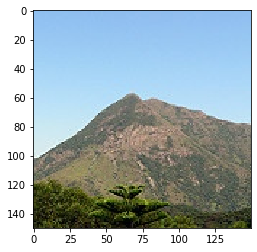

Prediction: mountain, Actual: mountain


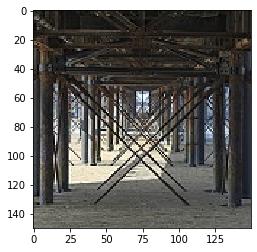

Prediction: street, Actual: buildings


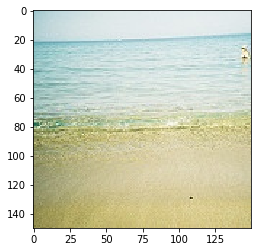

Prediction: mountain, Actual: sea


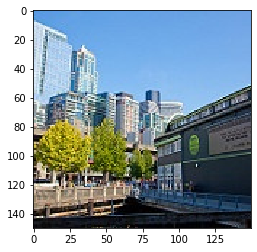

Prediction: mountain, Actual: buildings


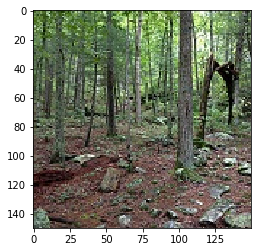

Prediction: forest, Actual: forest


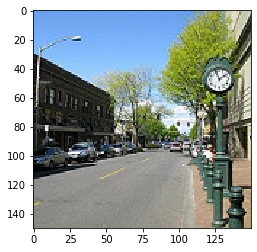

Prediction: street, Actual: street


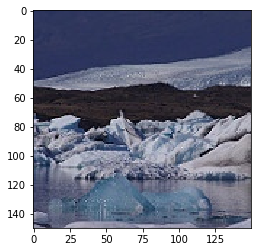

Prediction: glacier, Actual: glacier


In [74]:
# print some images with predicted labels for comparison
for i in range(len(X_test)):
    plt.imshow(X_test[i], interpolation='nearest')
    plt.show()
    print(f"Prediction: {labels_idx[y_pred_classes[i]]}, Actual: {labels_idx[y_test_classes[i]]}")

**Class by class analysis**

Drill-down on the model results to explore if it performed better on certain classes than others.

In [99]:
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_img_df,
        directory=dir_test,
        x_col="Images",
        y_col="Labels",
        target_size=(150, 150),
        batch_size=3000,
        class_mode='categorical')
X_test, y_test = next(test_generator)

Found 3000 validated image filenames belonging to 6 classes.


In [100]:
# generate predictions
y_pred = model.predict(x=X_test)

In [101]:
# retrieve the class labels from the prediction probabilities into a flattened array (predictions and true)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)

In [211]:
# get results into a dataframe
results_df = pd.DataFrame(data={"Actual":y_test_classes, "Predicted":y_pred_classes})
results_df.replace(labels_idx,inplace=True)
results_df['Correct'] = np.where(results_df['Actual']==results_df['Predicted'], 1, 0)

In [144]:
class_scores = pd.DataFrame(results_df.value_counts().reset_index().values, columns = ['Actual','Predicted','Correct','Count'])
class_scores.drop(columns='Correct',inplace=True)

In [205]:
# find proportions
class_scores

,Actual,Predicted,Count
0,street,street,404
1,mountain,mountain,402
2,glacier,glacier,387
3,forest,forest,381
4,buildings,buildings,277
5,sea,sea,220
6,sea,mountain,133
7,sea,glacier,110
8,glacier,mountain,94
9,buildings,street,93


In [210]:
# using pandas (show proportions)
pd.options.display.float_format = "{:,.2f}".format
result = pd.crosstab(index=results_df['Actual'], columns=results_df['Predicted'])
result.apply(lambda x: x/sum(x),axis=1)

Predicted,buildings,forest,glacier,mountain,sea,street
Actual,,,,,,
buildings,0.63,0.03,0.04,0.07,0.01,0.21
forest,0.02,0.80,0.00,0.01,0.01,0.15
glacier,0.04,0.01,0.70,0.17,0.05,0.02
mountain,0.04,0.00,0.12,0.77,0.06,0.01
sea,0.07,0.01,0.22,0.26,0.43,0.02
street,0.12,0.02,0.03,0.02,0.01,0.81


In [204]:
# using sklearn confusion matrix
from sklearn.metrics import confusion_matrix
accs = confusion_matrix(y_test_classes, y_pred_classes)
accs

array([[277,  15,  17,  30,   5,  93],
       [ 11, 381,   1,   7,   3,  71],
       [ 24,   6, 387,  94,  29,  13],
       [ 22,   1,  62, 402,  31,   7],
       [ 35,   4, 110, 133, 220,   8],
       [ 58,  12,  13,  11,   3, 404]], dtype=int64)

In [209]:
result["Accuracy"] = accs.diagonal() / accs.sum(axis=1)
result

Predicted,buildings,forest,glacier,mountain,sea,street,Accuracy
Actual,,,,,,,
buildings,277,15,17,30,5,93,0.63
forest,11,381,1,7,3,71,0.80
glacier,24,6,387,94,29,13,0.70
mountain,22,1,62,402,31,7,0.77
sea,35,4,110,133,220,8,0.43
street,58,12,13,11,3,404,0.81


**Save the model**

In [ ]:
# save the model as a h5 file or pb
model.save("my_keras_model.h5")